## Linear model problem

We consider the truth model $\mathcal{G}^{*}$
\begin{equation}
\label{eq:truth-reg}
    y = 4 + 3x + 2x^2 + x^3 + \cos(\pi x)
\end{equation}
and the domain of interest is $x\in[-2,\, 2]$.

However, due to the lack of knowledge, we have two misspecified models $\mathcal{G}$ with parameter vector $\theta$:
* Quadratic model:
    $$
    y = \theta_{(1)} + \theta_{(2)}x + \theta_{(3)}x^2.
    $$
* Cubic model:
    $$
    y = \theta_{(1)} + \theta_{(2)}x + \theta_{(3)}x^2 + \theta_{(4)}x^3.
    $$

In [1]:
using Random
using Distributions
using PyPlot
using LinearAlgebra

# Truth model
function true_G(x::Float64)
    val = 4 + 3x + 2x^2 + x^3 + cos(π * x)
    return val
end

# Misspecified model
function poly_model(x::Float64, θ::Array{Float64, 1})
    val = 0.0
    for i = 1:length(θ)
        val += θ[i]*x^(i-1)
    end
    return val
end

poly_model (generic function with 1 method)

## Bayesian measurement error model

Assume we collect $N_y$ observations from the truth model $\mathcal{G}^{*}$
$$
y_i = \mathcal{G}^{*}(x_i) + \eta_i, \qquad i=1,\,\cdots,\,N_y
$$
    
which are generated at uniform locations 

$$x_i = -2+\frac{4 (i - 1)}{N_y-1} \quad i= 1,\,\cdots,\,N_y.$$
    
with i.i.d. Gaussian observation errors $\eta_i \sim \mathcal{N}(0, 0.1^2)$.

The Bayesian measurement error mode can be formulated as following

$$ \mathbf{y} = \mathbf{G}(\mathbf{x})\cdot \theta + \boldsymbol{\eta} $$
    
where

$$
\begin{align*} 
&\mathbf{y} 
= \begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_{N_y}
\end{bmatrix}
\qquad 
\mathbf{G}(\mathbf{x}) 
= \begin{bmatrix}
1&x_1 & \cdots & x_1^{N_\theta-1}\\
1&x_2 & \cdots & x_2^{N_\theta-1}\\
\vdots\\
1&x_{N_y}& \cdots&  x_{N_y}^{N_\theta-1}\\
\end{bmatrix} \\
&\boldsymbol{\eta} \sim \mathcal{N}(\boldsymbol{0}, \Sigma_{\boldsymbol{\eta}}) \qquad 
\Sigma_{\boldsymbol{\eta}} = \textrm{diag}\Big(0.1^2,\,\cdots,\, 0.1^2\Big)
\end{align*}
$$

In [2]:
function data_gen(N_θ::Int64, N_y::Int64, σ_η::Float64 = 0.1; seed::Int64 = 123)
    # generate data
    xs_train = Array(LinRange(-2, 2, N_y))
    G = hcat([xs_train.^(i-1) for i = 1:N_θ]...)
    
    ys_train_ref = [true_G(xs_train[i]) for i = 1:length(xs_train)]

    y = copy(ys_train_ref)
    Random.seed!(seed); 
    for i = 1:length(y)
        noise = σ_η * rand(Normal(0, 1))
        y[i] += noise
    end
    Σ_η = Array(Diagonal(fill(σ_η^2, N_y)))
        
    return xs_train, y, G, Σ_η
end

data_gen (generic function with 2 methods)

## Posterior distribution $\mathcal{N}(m, C)$

* The posterior distribution with a Gaussian prior $\mathcal{N}(m_0, \Sigma_0)$ is 

    $$
    \begin{align*}
    &m = m_0 + \Sigma_0 G^T(\Sigma_{\eta} + G \Sigma_0 G^T)^{-1} (y - G m_0)\\
    &C = \Sigma_0 -\Sigma_0 G^T(\Sigma_{\eta} + G \Sigma_0G^T)^{-1} G\Sigma_0 \Big)
    \end{align*}
    $$

* The posterior distribution with an uninformation prior is

    $$
    \begin{align*}
    &m = (G^T \Sigma_{\eta}G)^{-1}  G^T \Sigma_{\eta}^{-1}y
    &C = (G^T \Sigma_{\eta}G)^{-1}
    \end{align*}
    $$



In [3]:
function compute_posterior(y::Array{Float64, 1}, G::Array{Float64, 2}, Σ_η::Array{Float64, 2}, 
            m0::Union{Array{Float64, 1} , Nothing}=nothing, Σ0::Union{Array{Float64, 2} , Nothing}=nothing)
    if m0 === nothing
        # compute posterior distribution with an uninformative prior
        m = (G'*(Σ_η\G))\(G'*(Σ_η\y))
        C = inv(G'*(Σ_η\G))
    else
        # compute posterior distribution with prior m0,Σ0
        m = m0 + Σ0*G'*((Σ_η + G*Σ0*G')\(y - G*m0))
        C = Σ0 - Σ0*G'*((Σ_η + G*Σ0*G')\(G*Σ0))
    end
    return m, C
end

compute_posterior (generic function with 3 methods)

## Predictive uncertainty estimation

* The truth $y$ with respect to any input $x$
    
    $$y^{*} = \mathcal{G}^{*}(x)$$
    
* The predictive uncertainty from Bayesian measurement error model is
    
    $$y \sim \mathcal{N}(g^T m,\, g^T C g)$$
    
  here $g = [1,\, x^1,\, \cdots,\, x^{N_\theta-1}]^T$
  
We consider both quadratic and cubic models with $N_y = 10$, the 3-$\sigma$ confidence interval for each prediction is ploted. And we hope the truth value $y^{*}$ is covered by the confidence interval with high probability.

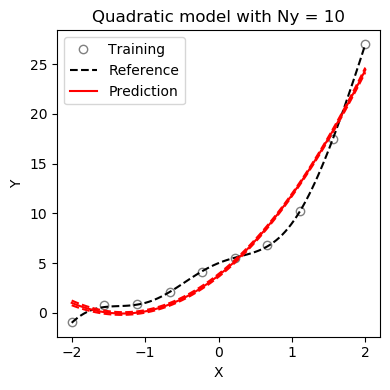

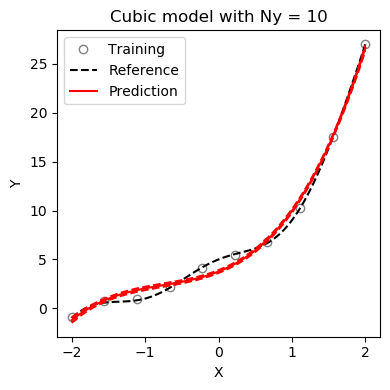

In [4]:
function prediction(xs_train, ys_train, xs_test, θ_mean, θθ_cov)
    
    N_test = length(xs_test)
    ys_test_ref = [true_G(xs_test[i]) for i = 1:N_test]
    
    
    ys_test_pred = [poly_model(xs_test[i], θ_mean) for i = 1:N_test]
    ys_test_cov = zeros(Float64, N_test)
    for i = 1:N_test
        g = [xs_test[i]^(j-1) for j = 1:N_θ]
        ys_test_cov[i] = g' * θθ_cov * g
    end
    ys_test_std = sqrt.(ys_test_cov)

    plot(xs_train, ys_train, "o", fillstyle="none", color="grey", label="Training")
    
    plot(xs_test, ys_test_ref, "--", color="black", fillstyle="none", label = "Reference", markevery=10)
    
    plot(xs_test, ys_test_pred, "-r", markevery=20, label="Prediction")
    plot(xs_test, ys_test_pred + 3ys_test_std, "--r")
    plot(xs_test, ys_test_pred - 3ys_test_std, "--r")
    
    
    xlabel("X")
    ylabel("Y")
    legend()
    
end

N_θ = 3
N_y = 10 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
# m0, Σ0 = [4.0;3.0;2.0], ones(Float64, N_θ, N_θ)
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)
xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Quadratic model with Ny = $(N_y)");
tight_layout()
savefig("Quadratic.png")


N_θ = 4
N_y = 10 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
# m0, Σ0 = [1.0;1.0;1.0;1.0], ones(Float64, N_θ, N_θ)
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)
xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Cubic model with Ny = $(N_y)");
tight_layout()
savefig("Cubic.png")

## Adjust observation error
The above results illustrate that the predictive uncertainty estimation obtained by the Bayesian measurement error model is malfunctioning. 

The malfunctioning is due to the model misspecification. 

A 2-round procedure is needed. In the first round, we estimate the posterior mean and covariance, 
```
m, C = compute_posterior(y, G, Ση, m0, Σ0)
```

and the model form error. We assume that each component of the model form error is independent and identially distributed zero-mean Gaussian $\mathcal{N}(0,\sigma_e^2)$, which is estimated by
$$
\begin{align*}
&\sigma_e^2 \approx \frac{1}{N_y} (\mathbf{y} - \mathbf{G}(\mathbf{x}) m \theta)^{T} (\mathbf{y} - \mathbf{G}(\mathbf{x}) m)\\
&\Sigma_{\boldsymbol{e}} = \textrm{diag}\Big(\sigma_e^2,\,\cdots,\, \sigma_e^2\Big)
\end{align*}
$$


In the second round, we estimate the posterior mean and covariance again with corrected observation error estimation $\Sigma_{\boldsymbol{e}}$, 
```
m, C = compute_posterior(y, G, Σe, m0, Σ0)
```

We consider the quadratic model with $N_y = 10$ and $N_y = 100$, the 3-$\sigma$ confidence interval for each prediction is ploted. And we hope the truth value $y^{*}$ is covered by the confidence interval with high probability.



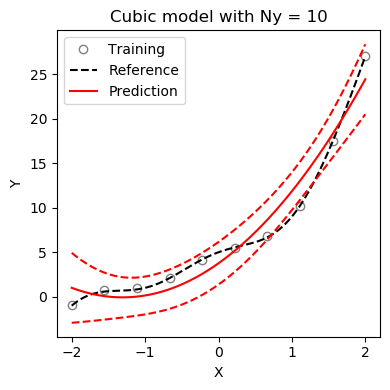

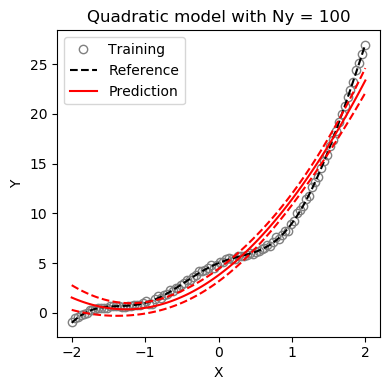

┌ Info: Estimated model error σ_e = 1.6649538779099513
└ @ Main In[5]:10
┌ Info: Estimated model error σ_e = 1.4074493259931695
└ @ Main In[5]:30


In [5]:
N_θ = 3
N_y = 10 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/N_y * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

xs_test = Array(LinRange(-2, 2, 1000))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Cubic model with Ny = $(N_y)");
tight_layout()


N_θ = 3
N_y = 100 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/(N_y) * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Quadratic model with Ny = $(N_y)");
tight_layout()

## Covariance matrix inflation

The above results illustrate that the predictive uncertainty estimation obtained by the corrected Bayesian measurement error model is sensitive to $N_y$, the number of observations. 

Inspired by the Bernstein-Von Mises theorem, which states that under certain regularity conditions, the posterior distribution asymptotically converges to a normal distribution as $N_y \rightarrow +\infty$

$$\mathcal{N}(\theta^{*}, N_y^{-1} I^{-1}(\theta^{*})) $$

here $\theta^{*}$ is the truth parameter for well-specified models, and the minimizer of the Kullback–Leibler between the truth model distribution and the mis-specified model distribution for mis-specified models. And $I$ is the fisher information matrix.

We inflate the covariance matrix as 

$$C := \frac{N_y}{N_\theta} C $$


We consider both quadratic and cubic models with $N_y = 10$ and $N_y = 100$, the 3-$\sigma$ confidence interval for each prediction is ploted. The truth value $y^{*}$ is covered by the confidence interval with high probability. And the confidence interval representes the fisher information matrix and is insensitive to $N_y$.

┌ Info: Estimated model error σ_e = 1.6649538779099513
└ @ Main In[6]:10
┌ Info: Estimated model error σ_e = 1.4074493259931695
└ @ Main In[6]:32


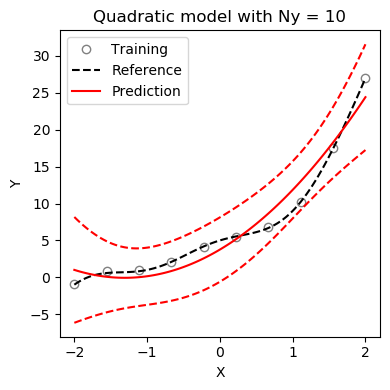

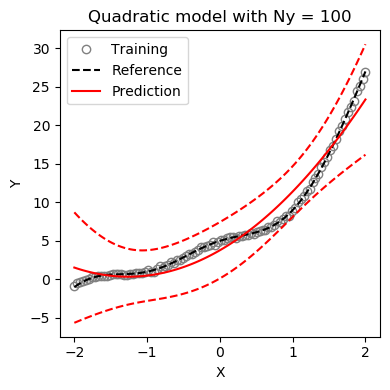

In [6]:
N_θ = 3
N_y = 10 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/(N_y) * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

# covariance matrix inflation
C *= N_y/N_θ

xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Quadratic model with Ny = $(N_y)");
tight_layout()

N_θ = 3
N_y = 100 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/(N_y) * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

# covariance matrix inflation
C *= N_y/N_θ

xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Quadratic model with Ny = $(N_y)");
tight_layout()


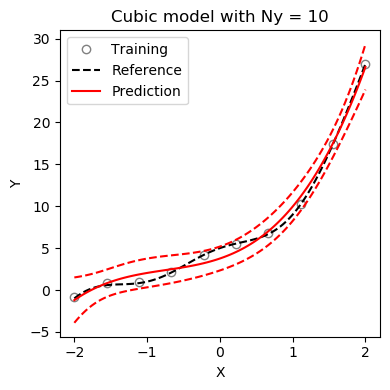

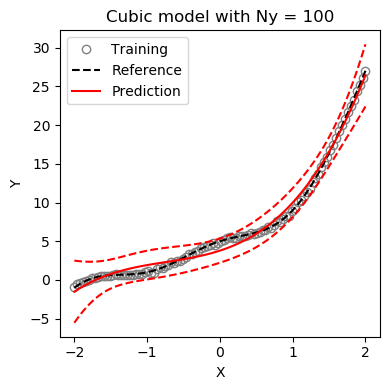

┌ Info: Estimated model error σ_e = 0.628683843937092
└ @ Main In[7]:10
┌ Info: Estimated model error σ_e = 0.6941368691213087
└ @ Main In[7]:32


In [7]:
N_θ = 4
N_y = 10 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/(N_y) * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

# covariance matrix inflation
C *= N_y/N_θ

xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Cubic model with Ny = $(N_y)");
tight_layout()

N_θ = 4
N_y = 100 
σ_η = 0.1
xs_train, y, G, Σ_η = data_gen(N_θ, N_y, σ_η)
m0, Σ0 = nothing, nothing
m, C = compute_posterior(y, G, Σ_η, m0, Σ0)

# compute model form error 
σ_e = sqrt(1/(N_y) * dot(y - G*m, y - G*m))
@info "Estimated model error σ_e = $(σ_e)"
Σ_e = Array(Diagonal(fill(σ_e^2, N_y)))
m, C = compute_posterior(y, G, Σ_e, m0, Σ0)

# covariance matrix inflation
C *= N_y/N_θ

xs_test = Array(LinRange(-2, 2, 100))
figure(figsize=(4,4))
prediction(xs_train, y, xs_test, m, C)
title("Cubic model with Ny = $(N_y)");
tight_layout()